Maud+ 2017: https://ui.adsabs.harvard.edu/abs/2017MNRAS.467L.120M/abstract

Central source is W33A MM1-Main

https://ui.adsabs.harvard.edu/abs/2018A%26A...619A.107S/abstract

Distance from Reid via POETS above

ALMA archive search:
    https://almascience.eso.org/aq/?result_view=observation&raDec=273.664636%20%20-17.866724,%200.1

Luke Maud has additional data at 0.024" resolution

In [1]:
from astropy import units as u
parallax = 0.396 *u.mas # https://ui.adsabs.harvard.edu/abs/2014ApJ...783..130R/abstract
#distance = 3.8 * u.kpc # GUESS
distance = (u.au / parallax).to(u.kpc, u.dimensionless_angles())
distance

<Quantity 2.52525253 kpc>

In [2]:
cd /orange/adamginsburg/salt/sanhueza/W33A/

/orange/adamginsburg/salt/sanhueza/W33A


In [3]:
ls

big.reg
ipython_log_2021-09-29.py
KCl_v_le_2_stackcube.fits
KCl_v_le_4_stackcube.fits
NaCl_v_le_3_stackcube.fits
small.reg
spectra/
vmap.fits
W33A.config8.cont_avg.selfcal_0.5_hogbom.image.fits
W33A.config8.spw0.robust0.5.image_cb_smaller.fits
W33A.config8.spw0.robust0.5.image_small.fits
W33A.config8.spw1.robust0.5.image_cb_smaller.fits
W33A.config8.spw1.robust0.5.image_small.fits
W33A.config8.spw2.robust0.5.image_cb_smaller.fits
W33A.config8.spw2.robust0.5.image_small.fits
W33A.config8.spw3.robust0.5.image_cb_smaller.fits
W33A.config8.spw3.robust0.5.image_small.fits*
W33A_m0m1_grid_ticks.png
W33A_NaCl_mom0_ticks.png
W33A_NaCl_mom0_ticks_withcont.png
W33A.zip


In [4]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b0149677a60>

In [5]:
from astropy.table import Table
from astropy import table

In [6]:
import pprint

In [7]:
import scipy, scipy.ndimage

In [8]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord, visualization
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [9]:
from astropy.coordinates import SkyCoord

In [10]:
center = SkyCoord('18:14:39.510', '-17:52:00.143', frame='icrs', unit=(u.h, u.deg))

In [11]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('big.reg')
regsm = regions.Regions.read('small.reg')
regvsm = regions.Regions([regions.RectangleSkyRegion(center=center, width=0.3*u.arcsec, height=0.3*u.arcsec)])
#egvsm = regions.Regions.read('sourceAsmaller.reg')
#regvvsm = regions.Regions.read('.reg')

In [12]:
cat small.reg

# Region file format: DS9 CARTA 2.0.0
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
icrs
box(273.664636, -17.866724, 0.5879", 0.6897", 0) # color=#2EE6D6 width=2


In [13]:
cat big.reg

# Region file format: DS9 CARTA 2.0.0
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
icrs
box(273.664636, -17.866724, 2.0", 2.0", 0) # color=#2EE6D6 width=2



(2277.0, 2518.0, 2521.0, 2762.0)

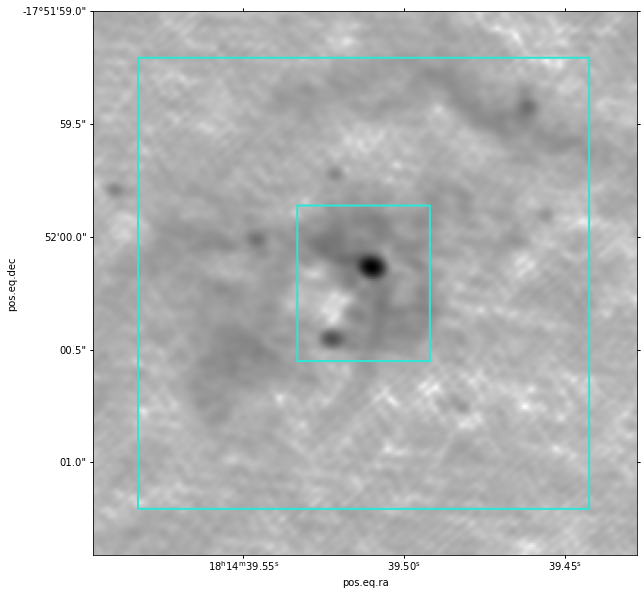

In [14]:
cont = SpectralCube.read('W33A.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r', norm=visualization.simple_norm(cont[0].value, stretch='log'))
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
regsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
#regvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
#regvvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# NaCl Stackl

In [15]:
from spectral_cube.analysis_utilities import stack_cube

In [16]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [17]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [18]:
flist = sorted(glob.glob('W33A.config8.spw[0-3].robust0.5.image_small.fits'))

In [19]:
import dask
dask.config.set(scheduler='threads', num_workers=8)

In [20]:
for fn in flist:
    outfile = fn.replace("_small","_cb_smaller")
    if not os.path.exists(outfile) or SpectralCube.read(outfile).unit != u.K:
        cube = SpectralCube.read(fn, use_dask=True).subcube_from_regions(reg)
        print(cube)
        cube.allow_huge_operations=True
        cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
        scube = cube.convolve_to(cb)
        scube.allow_huge_operations=True
        scube.to(u.K).write(outfile, overwrite=True)

In [21]:
cbflist = sorted((glob.glob('W33A.config8.spw[0-3].robust0.5.image_cb_smaller.fits')))
cubes = [SpectralCube.read(fn, use_dask=True).subcube_from_regions(regsm) for fn in cbflist]
cubes

[DaskSpectralCube with shape=(1931, 69, 59) and unit=K and chunk size (434, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562367862.000 Hz:235447230123.057 Hz,
 DaskSpectralCube with shape=(1930, 69, 59) and unit=K and chunk size (386, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062373964.100 Hz:232946259612.704 Hz,
 DaskSpectralCube with shape=(3860, 69, 59) and unit=K and chunk size (386, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   3860  type

In [22]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    cb = cubes[0].beam

In [23]:
cb

Beam: BMAJ=0.09669544547796216 arcsec BMIN=0.06535904854536036 arcsec BPA=-83.22697448730469 deg

In [24]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 244.18041787 AU>

In [25]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 165.04810239 AU>

In [26]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [27]:
from astropy import log
log.setLevel('INFO')

In [28]:
cubes

[DaskSpectralCube with shape=(1931, 69, 59) and unit=K and chunk size (434, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562367862.000 Hz:235447230123.057 Hz,
 DaskSpectralCube with shape=(1930, 69, 59) and unit=K and chunk size (386, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062373964.100 Hz:232946259612.704 Hz,
 DaskSpectralCube with shape=(3860, 69, 59) and unit=K and chunk size (386, 69, 59):
  n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
  n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
  n_s:   3860  type

In [29]:
#log.setLevel('DEBUG')
vcen = 35 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [30]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(90, 69, 59) and unit=K:
 n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
 n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
 n_s:     90  type_s: VRAD      unit_s: km / s  range:        5.160 km / s:      64.930 km / s

invalid value encountered in divide


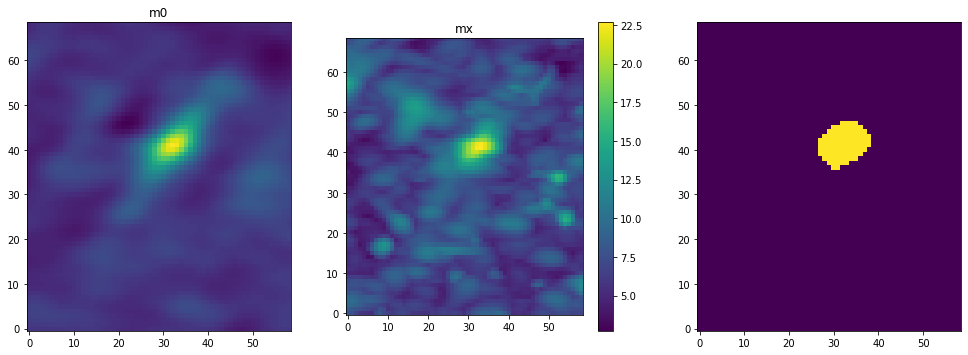

<Figure size 432x288 with 0 Axes>

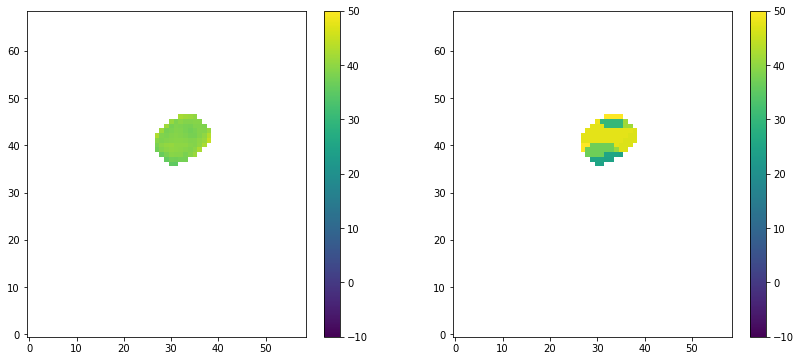

In [31]:
stackc = stackc.subcube_from_regions(regsm)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 15*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=3)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()



from dask_image.ndmorph import binary_dilation, binary_erosion
from scipy.ndimage import binary_dilation, binary_erosion
m3d = (stackc > 10*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
#m3d = m3d.compute()



m1 = stackc.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=50)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=50)
pl.colorbar()


vmap = m1.hdu

DaskSpectralCube with shape=(1930, 69, 59) and unit=K and chunk size (386, 69, 59):
 n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
 n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062373964.100 Hz:232946259612.704 Hz
DaskSpectralCube with shape=(32, 69, 59) and unit=K and chunk size (32, 69, 59):
 n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
 n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
 n_s:     32  type_s: VRAD      unit_s: km / s  range:       15.382 km / s:      54.388 km / s


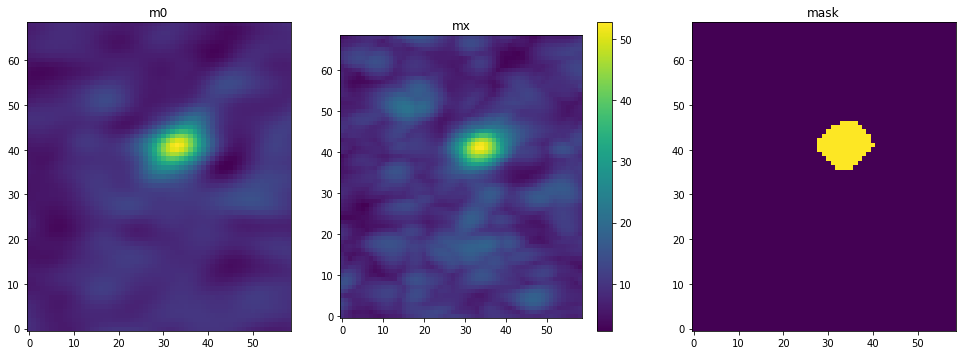

<Figure size 432x288 with 0 Axes>

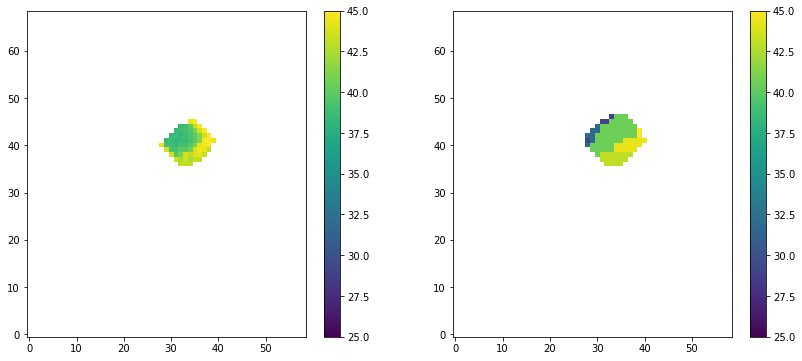

In [32]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.with_spectral_unit(u.GHz).spectral_extrema[0] < restval) & (c.with_spectral_unit(u.GHz).spectral_extrema[1] > restval)][0]
print(cube)
scube = (cube.subcube_from_regions(regsm)
         .with_spectral_unit(u.GHz)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 35*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=3)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 30*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()

m1 = scube.with_mask(msk).with_mask(m3d).moment1()
m0m = scube.with_mask(msk).with_mask(m3d).moment0()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar()

#pl.figure()
#pl.imshow(m0m.value)
#m0m.hdu.writeto('water_masked_moment0.fits', overwrite=True)

vmap = m1.hdu

In [33]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

bad lines: []  [] GHz


In [34]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(regsm).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [35]:
mkdir -p spectra/figures

spw1
spw2


spw3
spw4


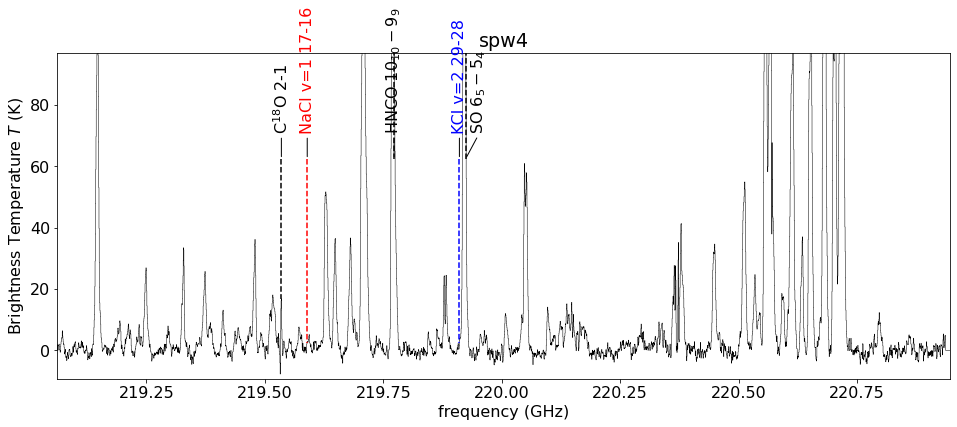

In [36]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

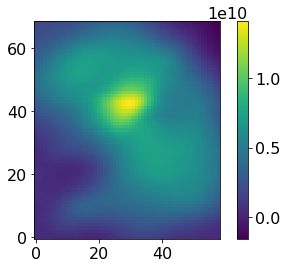

In [37]:
m0ch3cn = cubes[-1].spectral_slab(220.5*u.GHz, 220.65*u.GHz).moment0()
m0ch3cn.quicklook(use_aplpy=False)
pl.colorbar()

In [38]:
ls spectra/figures

color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
color_labels_W33A.config8.spw0_5_stack.png
color_labels_W33A.config8.spw1_5_stack.png
color_labels_W33A.config8.spw2_5_stack.png
color_labels_W33A.config8.spw3_5_stack.png
color_labels_W33Amm1_spw0_stack.png
color_labels_W33Amm1_spw1_stack.png
color_labels_W33Amm1_spw2_stack.png
color_labels_W33Amm1_spw3_stack.png
gallery.html
spw1.png
spw2.png
spw3.png
spw4.png
style.css
W33A.config8.spw0_5_stack.png
W33A.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
W33A.config8.spw0.robust0.5.image_cb_smaller_stack.png
W33A.config8.spw0.robust0.5.image_cb_smaller_W33A_stack.pdf
W33A.config8.spw0.robust0.5.image_cb_smaller_W33A_stack.png
W33A.config8.spw1_5_stack.png
W33A.config8.spw1.robust0.5.image_cb_smaller_stack.pdf
W33A.config8.spw1.robust0.5.image_cb_smaller_stack.png
W33A.config8.spw1.robust0.5.image_cb_smaller_W33A_stack.pdf
W33A.config8.spw1.robust0.5.image_cb_smaller_W33A_stack.png
W33A.config8.spw2

In [39]:
from IPython.display import Image,display

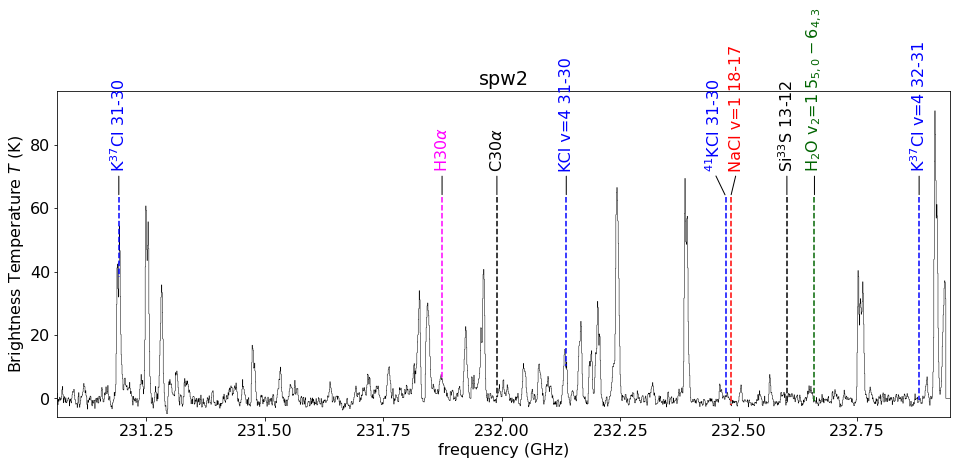

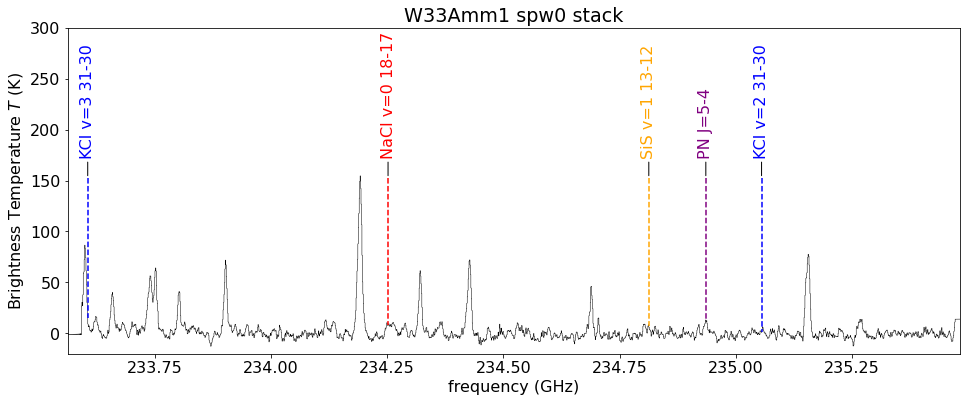

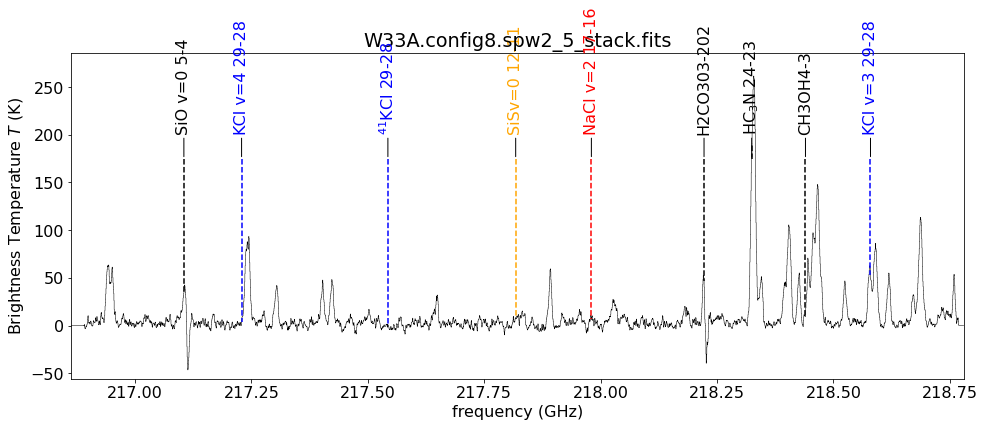

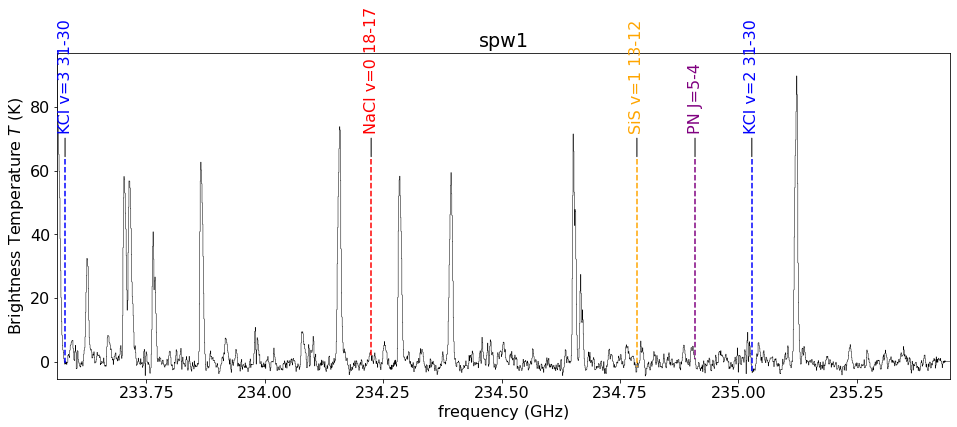

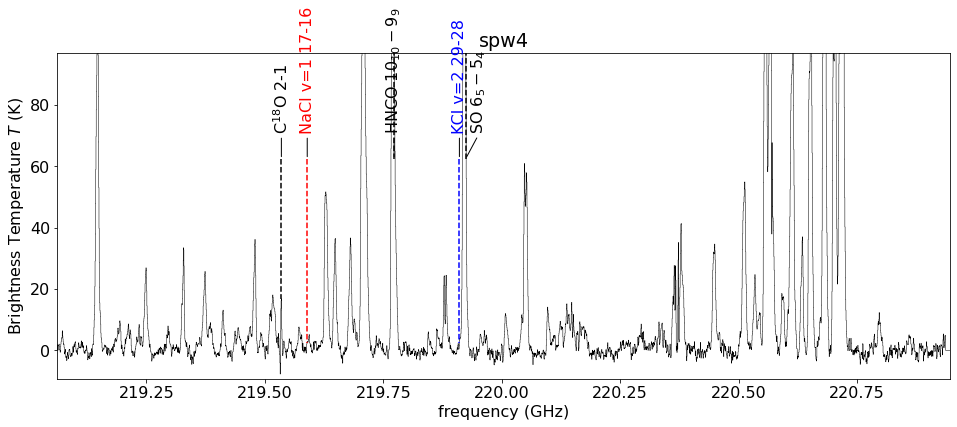

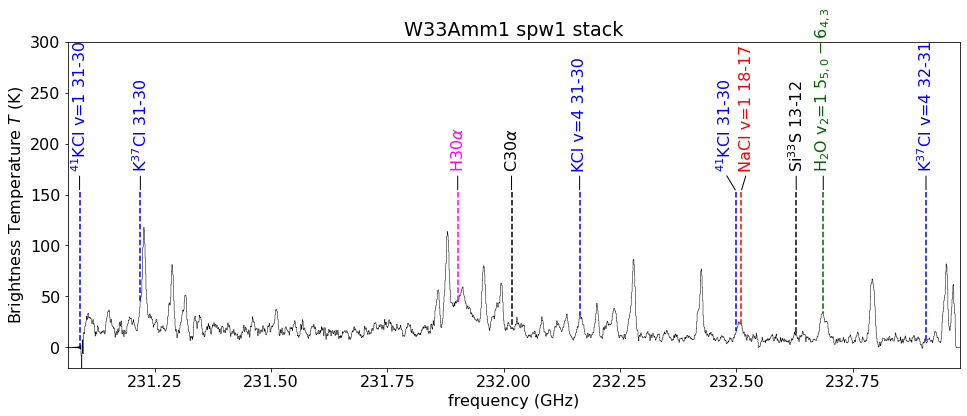

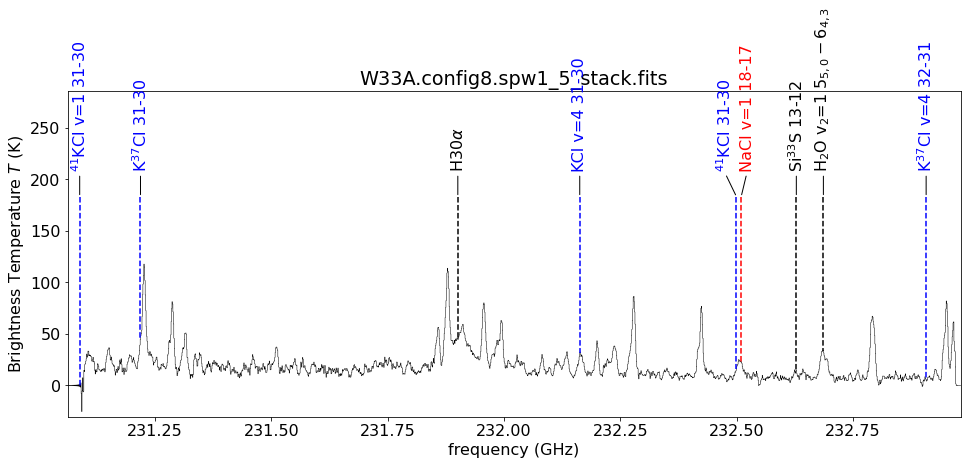

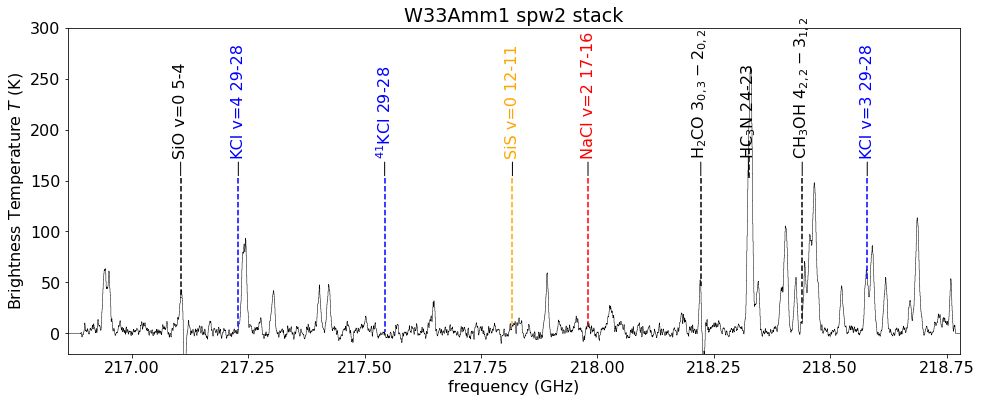

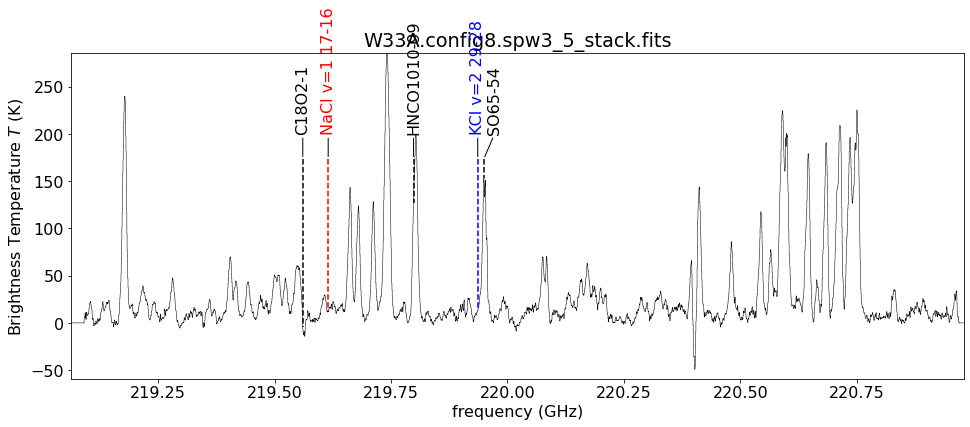

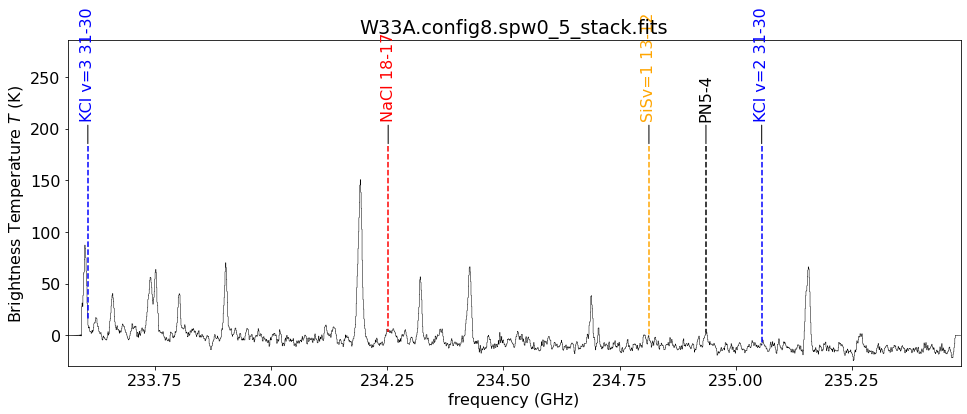

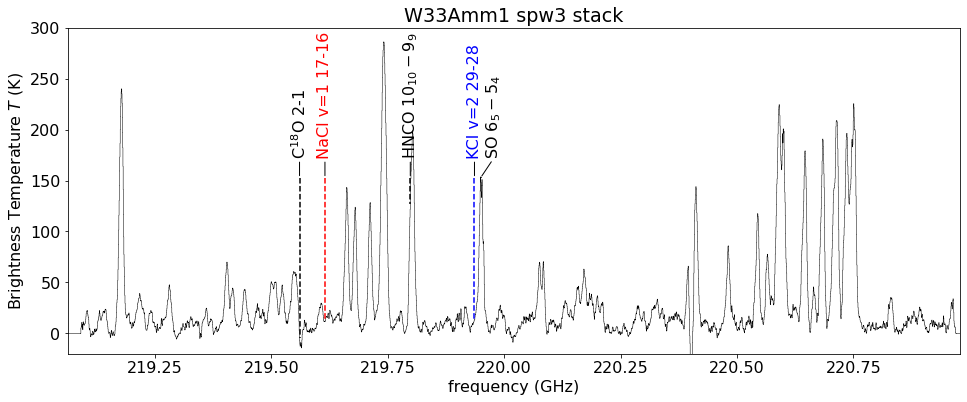

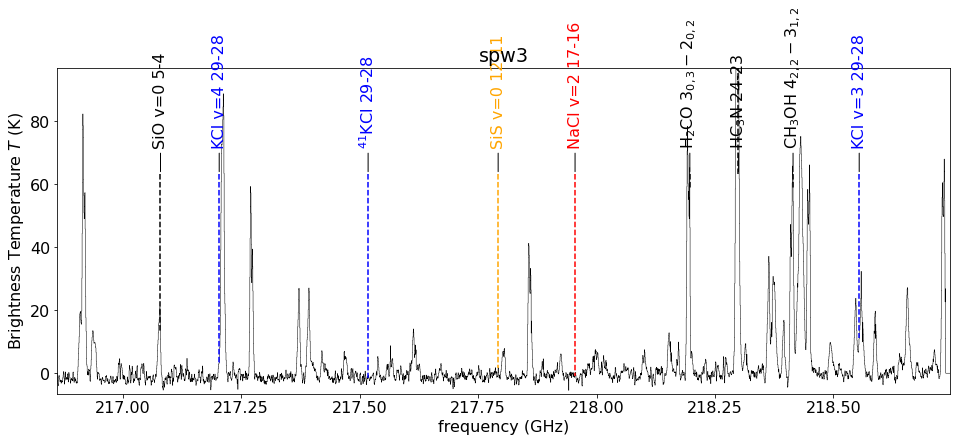

In [40]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

DaskSpectralCube with shape=(1931, 200, 193) and unit=K and chunk size (434, 200, 193):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.867000 deg:  -17.866447 deg
 n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562367862.000 Hz:235447230123.057 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(1930, 200, 193) and unit=K and chunk size (386, 200, 193):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.867000 deg:  -17.866447 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062373964.100 Hz:232946259612.704 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3860, 200, 193) and unit=K and chunk size (386, 200, 193):
 n_x:    193  type_x: RA---SIN  unit_x: deg    range:   273.664346 deg:  273.664907 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -17.86

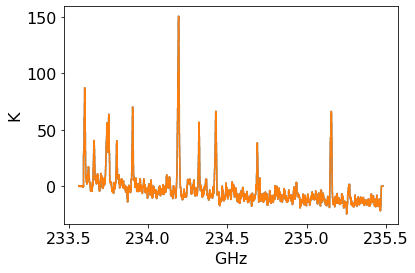

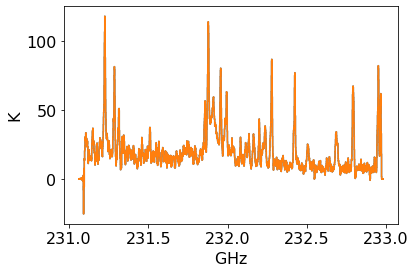

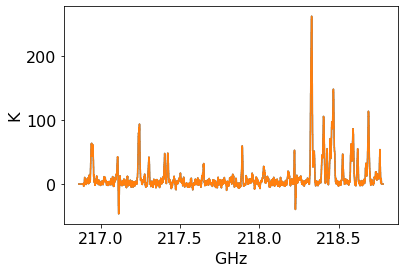

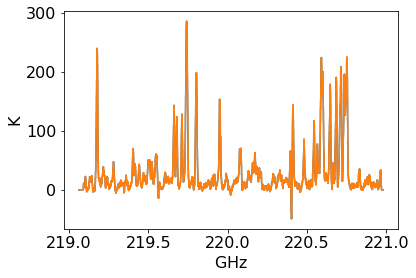

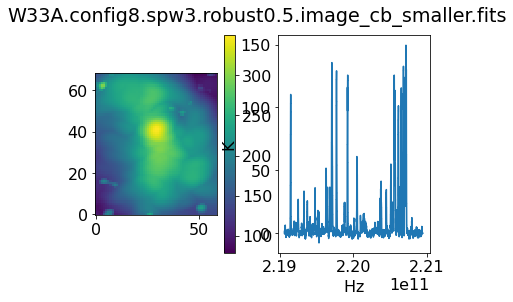

In [41]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy.io import fits

for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(regsm)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    fits.PrimaryHDU(data=vmap_proj.value, header=scube.wcs.celestial.to_header()).writeto('vmap.fits', overwrite=True)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"W33A Stack")
    fstack.write(f'spectra/{basename}_W33A_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_W33A_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_W33A_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

### ls spectra

In [42]:
stackspectra = []
for ii,fn in enumerate(sorted(glob.glob('spectra/*_stack.fits'))):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'W33Amm1 {fn.split(".")[2]} stack'
    print(fn, pysp.specname)
    stackspectra.append(pysp)

spectra/W33A.config8.spw0.robust0.5.image_cb_smaller_W33A_stack.fits W33Amm1 spw0 stack
spectra/W33A.config8.spw0.robust0.5.image_cb_smaller_stack.fits W33Amm1 spw0 stack
spectra/W33A.config8.spw1.robust0.5.image_cb_smaller_W33A_stack.fits W33Amm1 spw1 stack
spectra/W33A.config8.spw1.robust0.5.image_cb_smaller_stack.fits W33Amm1 spw1 stack
spectra/W33A.config8.spw2.robust0.5.image_cb_smaller_W33A_stack.fits W33Amm1 spw2 stack
spectra/W33A.config8.spw2.robust0.5.image_cb_smaller_stack.fits W33Amm1 spw2 stack
spectra/W33A.config8.spw3.robust0.5.image_cb_smaller_W33A_stack.fits W33Amm1 spw3 stack
spectra/W33A.config8.spw3.robust0.5.image_cb_smaller_stack.fits W33Amm1 spw3 stack


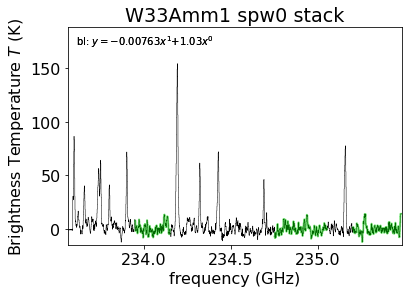

In [43]:
spw0 = stackspectra[0]
spw0.plotter()
spw0.baseline(exclude=[230, 233.95, 234.15, 234.75, 235.05, 235.2, ], highlight_fitregion=True)

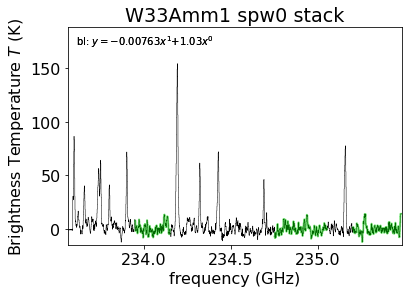

In [44]:
spw0 = stackspectra[1] # there are two spw0's
spw0.plotter()
spw0.baseline(exclude=[230, 233.95, 234.15, 234.75, 235.05, 235.2, ], highlight_fitregion=True)

W33Amm1_spw0_stack
W33Amm1_spw0_stack
W33Amm1_spw1_stack
W33Amm1_spw1_stack
W33Amm1_spw2_stack
W33Amm1_spw2_stack
W33Amm1_spw3_stack
W33Amm1_spw3_stack


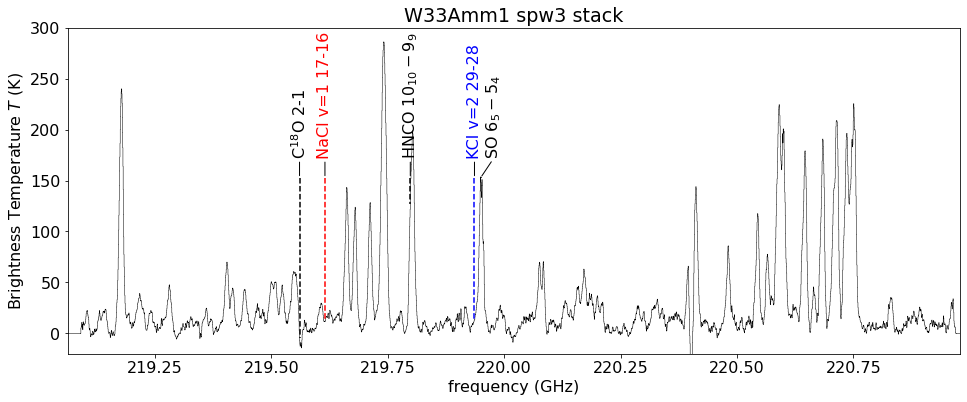

In [45]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures', ymax=300, ymin=-20, yfrac=0.6)

In [46]:
ls spectra/figures/

color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
color_labels_W33A.config8.spw0_5_stack.png
color_labels_W33A.config8.spw1_5_stack.png
color_labels_W33A.config8.spw2_5_stack.png
color_labels_W33A.config8.spw3_5_stack.png
color_labels_W33Amm1_spw0_stack.png
color_labels_W33Amm1_spw1_stack.png
color_labels_W33Amm1_spw2_stack.png
color_labels_W33Amm1_spw3_stack.png
gallery.html
spw1.png
spw2.png
spw3.png
spw4.png
style.css
W33A.config8.spw0_5_stack.png
W33A.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
W33A.config8.spw0.robust0.5.image_cb_smaller_stack.png
W33A.config8.spw0.robust0.5.image_cb_smaller_W33A_stack.pdf
W33A.config8.spw0.robust0.5.image_cb_smaller_W33A_stack.png
W33A.config8.spw1_5_stack.png
W33A.config8.spw1.robust0.5.image_cb_smaller_stack.pdf
W33A.config8.spw1.robust0.5.image_cb_smaller_stack.png
W33A.config8.spw1.robust0.5.image_cb_smaller_W33A_stack.pdf
W33A.config8.spw1.robust0.5.image_cb_smaller_W33A_stack.png
W33A.config8.spw2

spectra/figures/color_labels_W33Amm1_spw0_stack.png


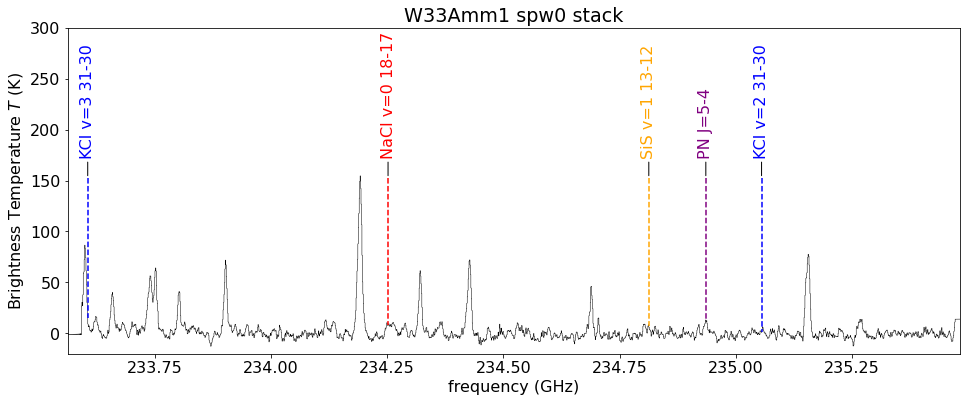

spectra/figures/color_labels_W33Amm1_spw1_stack.png


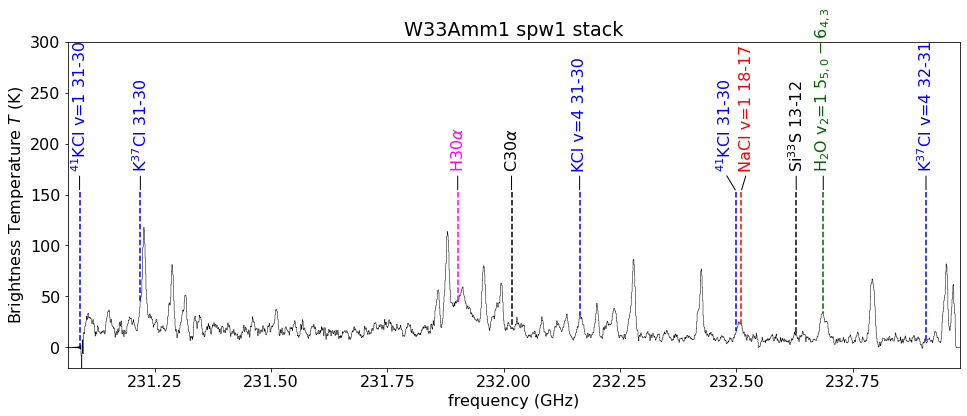

spectra/figures/color_labels_W33Amm1_spw2_stack.png


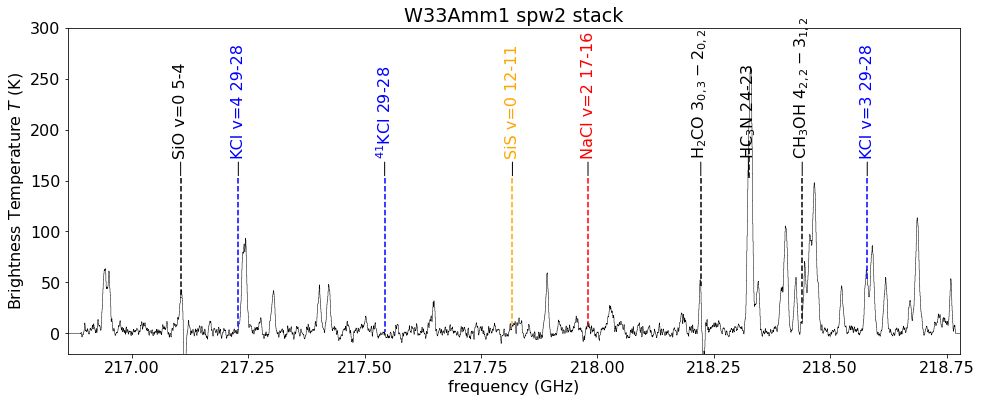

spectra/figures/color_labels_W33Amm1_spw3_stack.png


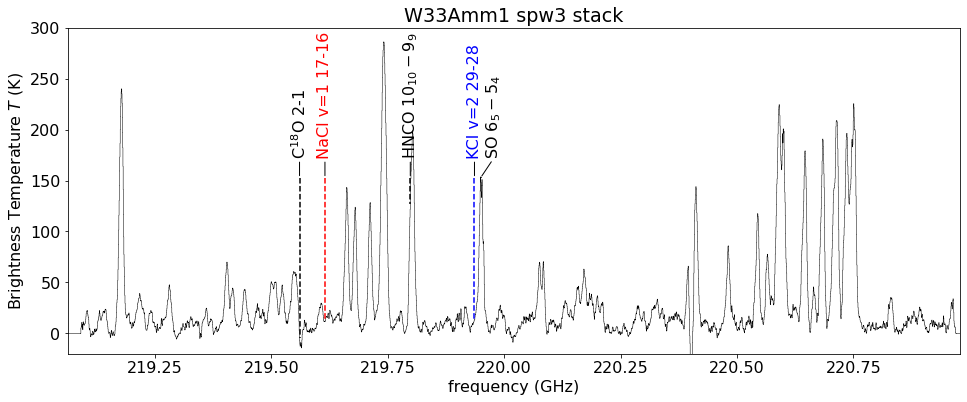

In [47]:
for fn in glob.glob('spectra/figures/color*spw[0-4]_stack.png'):
    print(fn)
    display(Image(fn))

In [48]:
# table 5 is double-rare, not detected

kcltables = salt_tables[:3]#  + salt_tables[5:]

# cubes are already loaded
# cubes = [SpectralCube.read(fn).subcube_from_regions([reg]) for fn in (glob.glob('G17_SPW[0-3]_2017.image.fits'))]
# beams = radio_beam.Beams(beams=[cube.beams.common_beam() for cube in cubes])
# cb=beams.common_beam()
linelistK = np.concatenate([data['Freq'][(data['vu'] <= 4) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in kcltables])
linenamesK = np.concatenate( [data['Species'][(data['vu'] <= 4) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in kcltables] )
print(linelistK, linenamesK)
rows = [data[(data['vu'] <= 4) &
             np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                      (data['Freq'].quantity < cube.spectral_extrema[1]))
                     for cube in cubes],
                    axis=0)]
        for data in kcltables]
KCl_inband = table.vstack(rows)
print(KCl_inband)

# exclude lines with contaminants
# 41KCl v=4 J=30-20 is the worst, apparently, b/c of NaCl v=1 17-16
# 41KCl v=0 J=31-30 is on top of NaCl v=1 18-17
# KCl v=2 29-28 is double-peaked; not clear what's up there
# 41KCl v=0 J=29-28 just looks like a nondetection?
# 39K-37Cl v=4 J=30-29 nondetection
# 39K-37Cl v=3 J=32-31 nondetection
# 41K-35Cl v=1 J=31-30 nondetection
exclude = ('41K-35Clv=0-0 J=31-30',
           '41K-35Clv=4-4 J=30-29',
           '39K-35Clv=2-2 J=29-28',
           '41K-35Clv=0-0 J=29-28',
           '39K-37Clv=4-4 J=30-29',
           '39K-37Clv=3-3 J=32-31',
           '41K-35Clv=1-1 J=31-30',           
          )
incl = np.all([linenamesK != ex for ex in exclude], axis=0)
linelistK = linelistK[incl]
linenamesK = linenamesK[incl]
linelistK, linenamesK
pprint.pprint(dict(zip(linelistK, linenamesK)))

[217.22891176 218.5797076  219.93611261 232.16184646 233.60569798
 235.05557839 218.39656825 219.73475809 231.21883931 232.90755269
 234.33493148 217.54316883 219.59177028 220.941078   231.08814962
 232.49980161 234.18192351] GHz ['39K-35Clv=4-4 J=29-28' '39K-35Clv=3-3 J=29-28' '39K-35Clv=2-2 J=29-28'
 '39K-35Clv=4-4 J=31-30' '39K-35Clv=3-3 J=31-30' '39K-35Clv=2-2 J=31-30'
 '39K-37Clv=4-4 J=30-29' '39K-37Clv=3-3 J=30-29' '39K-37Clv=0-0 J=31-30'
 '39K-37Clv=4-4 J=32-31' '39K-37Clv=3-3 J=32-31' '41K-35Clv=0-0 J=29-28'
 '41K-35Clv=4-4 J=30-29' '41K-35Clv=3-3 J=30-29' '41K-35Clv=1-1 J=31-30'
 '41K-35Clv=0-0 J=31-30' '41K-35Clv=4-4 J=32-31']
upper_state lower_state    Aij    Frequency_cm        Freq               E_U                E_L              QNs       vu  vl  Ju  Jl  gu   gl         Species       
                          1 / s      1 / cm           GHz                 K                  K                                                                       
----------- -----------

In [49]:
stackK, cutoutsK = stack_cube(cubes,
                   linelist=linelistK,
                   vmin=-60*u.km/u.s,
                   vmax=-5*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
stackK.to(u.K).write('KCl_v_le_4_stackcube.fits', overwrite=True)

In [50]:
stackKc = SpectralCube.read('KCl_v_le_4_stackcube.fits', use_dask=True)
stackKc

DaskSpectralCube with shape=(83, 69, 59) and unit=K and chunk size (83, 69, 59):
 n_x:     59  type_x: RA---SIN  unit_x: deg    range:   273.664551 deg:  273.664720 deg
 n_y:     69  type_y: DEC--SIN  unit_y: deg    range:   -17.866819 deg:  -17.866631 deg
 n_s:     83  type_s: VRAD      unit_s: km / s  range:      -59.937 km / s:      -4.677 km / s

In [51]:
# table 5 is double-rare, not detected

kcltables = salt_tables[:3]#  + salt_tables[5:]

# cubes are already loaded
# cubes = [SpectralCube.read(fn).subcube_from_regions([reg]) for fn in (glob.glob('G17_SPW[0-3]_2017.image.fits'))]
# beams = radio_beam.Beams(beams=[cube.beams.common_beam() for cube in cubes])
# cb=beams.common_beam()
linelistK = np.concatenate([data['Freq'][(data['vu'] <= 2) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in kcltables])
linenamesK = np.concatenate( [data['Species'][(data['vu'] <= 2) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in kcltables] )
print(linelistK, linenamesK)
rows = [data[(data['vu'] <= 2) &
             np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                      (data['Freq'].quantity < cube.spectral_extrema[1]))
                     for cube in cubes],
                    axis=0)]
        for data in kcltables]
KCl_inband = table.vstack(rows)
print(KCl_inband)

# exclude lines with contaminants
# 41KCl v=4 J=30-20 is the worst, apparently, b/c of NaCl v=1 17-16
# 41KCl v=0 J=31-30 is on top of NaCl v=1 18-17
# KCl v=2 29-28 is double-peaked; not clear what's up there
# 41KCl v=0 J=29-28 just looks like a nondetection?
# 39K-37Cl v=4 J=30-29 nondetection
# 39K-37Cl v=3 J=32-31 nondetection
# 41K-35Cl v=1 J=31-30 nondetection
exclude = ('41K-35Clv=0-0 J=31-30',
           '41K-35Clv=4-4 J=30-29',
           '39K-35Clv=2-2 J=29-28',
           '41K-35Clv=0-0 J=29-28',
           '39K-37Clv=4-4 J=30-29',
           '39K-37Clv=3-3 J=32-31',
           '41K-35Clv=1-1 J=31-30',           
          )
incl = np.all([linenamesK != ex for ex in exclude], axis=0)
linelistK = linelistK[incl]
linenamesK = linenamesK[incl]
linelistK, linenamesK
pprint.pprint(dict(zip(linelistK, linenamesK)))

stackK, cutoutsK = stack_cube(cubes,
                   linelist=linelistK,
                   vmin=-60*u.km/u.s,
                   vmax=-5*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
stackK.to(u.K).write('KCl_v_le_2_stackcube.fits', overwrite=True)

[219.93611261 235.05557839 231.21883931 217.54316883 231.08814962
 232.49980161] GHz ['39K-35Clv=2-2 J=29-28' '39K-35Clv=2-2 J=31-30' '39K-37Clv=0-0 J=31-30'
 '41K-35Clv=0-0 J=29-28' '41K-35Clv=1-1 J=31-30' '41K-35Clv=0-0 J=31-30']
upper_state lower_state    Aij    Frequency_cm        Freq               E_U                E_L              QNs       vu  vl  Ju  Jl  gu   gl        Species       
                          1 / s      1 / cm           GHz                 K                  K                                                                      
----------- ----------- --------- ------------ ------------------ ------------------ ------------------ ------------- --- --- --- --- ---- --- ---------------------
       1033        1032 0.0066713     7.335813 219.93611261476423  953.5558794307203  943.0012778144056 v=2-2 J=29-28   2   2  29  28  944 912 39K-35Clv=2-2 J=29-28
       1035        1034  0.008155     7.840115 235.05557839444083  975.7535062213024  964.4733263078973 v=2-

In [52]:
restval * (1-vcen/constants.c)

<Quantity 232.65953443 GHz>

xc=14.530483030174167, yc=14.699804887778456, dp_60 = 2.3759999999998103
axlims=(-0.5, 29.5, -0.5, 29.5)


contrms=0.00029805608033518137 Jy / beam, contmax=0.024411028251051903 Jy / beam


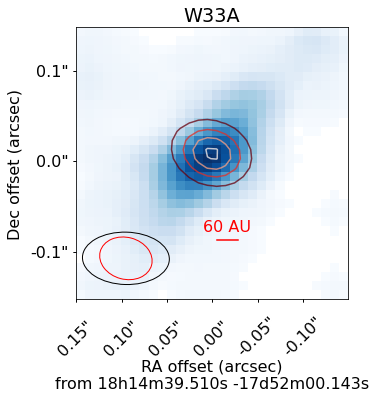

In [57]:
slcs = slice(None), slice(None), slice(None) #slice(4,-1), slice(6,-6)
m3d = (stackc.subcube_from_regions(regvsm) > 5*u.K).include()
m3d = scipy.ndimage.binary_erosion(m3d, iterations=1)
m3d = scipy.ndimage.binary_dilation(m3d, iterations=2)

m0 = stackc.subcube_from_regions(regvsm).with_mask(m3d)[slcs].moment0()

pixscale_au = (stackc.wcs.proj_plane_pixel_area()**0.5 * distance).to(u.au, u.dimensionless_angles())
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(m0.wcs)**0.5*u.deg).to(u.arcsec))

fig = pl.figure(figsize=(5,5))
ax1 = pl.subplot(1,1,1, projection=m0.wcs)
im1 = ax1.imshow(m0.value, cmap='Blues', origin='lower')
ax1.set_title("W33A")
axlims = ax1.axis()

offset_loc = regvsm[0].center

#ax = fig.add_subplot(111,frameon=False)
#pl.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#offset_loc = coordinates.SkyCoord("17:26:42.344 -36:09:16.14", unit=(u.h, u.deg), frame='icrs')
xc,yc = m0.wcs.celestial.world_to_pixel(offset_loc)

ax_ = ax1

xtlocs = ax_.get_xticks()
xticklabels = map(lambda x: f"{x:0.3f}", (xc-xtlocs)*pixscale.value)
ax_.set_xticks(xtlocs, xticklabels, rotation=45)
#ax_.axhline(yc, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
#ax_.axvline(xc, color='k', linestyle='--', linewidth=0.5, alpha=0.5)

ytlocs = ax1.get_yticks()
yticklabels = map(lambda x: f"{x:0.3f}", (ytlocs-yc)*pixscale.value)
ax_.set_yticks(ytlocs, yticklabels, rotation=0)

ax_.axis(axlims)

ra = ax_.coords['ra']
ra.set_auto_axislabel(False)
dec = ax_.coords['dec']
ra.set_coord_type('longitude', 180)
overlay = ax_.get_coords_overlay(offset_loc.skyoffset_frame())
ra.set_ticklabel_visible(False)
dec.set_ticklabel_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)

lon = overlay['lon']
lon.set_coord_type('longitude', 180)
lon.set_format_unit(u.arcsec)
lon.set_ticklabel(rotation=45, pad=40)
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lon.set_axislabel(" ")
lon.set_ticks(spacing=0.05*u.arcsec)
lat = overlay['lat']
lat.set_format_unit(u.arcsec)
lat.set_ticklabel()
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
lat.set_axislabel(" ")    

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)

dp_60 = (60*u.au / pixscale_au).decompose()

print(f"xc={xc}, yc={yc}, dp_60 = {dp_60}")
xc_ = 15
ax1.plot([xc_, xc_+dp_60], [6,6], color='r')
ax1.text(xc_ + dp_60/2, 7, f'60 AU', horizontalalignment='center', color='r')
print(f"axlims={axlims}")


lon.set_axislabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}")
lat.set_axislabel("Dec offset (arcsec)")#, labelpad=25)

ax1.axis(axlims)

pl.savefig("W33A_NaCl_mom0_ticks.png", bbox_inches='tight', dpi=300)

contcutout = cont.subcube_from_regions(regvsm)
contrms = cont.mad_std()
contrms = contcutout.mad_std()
print(f"contrms={contrms}, contmax={contcutout.max()}")
ax1.contour(contcutout[0], transform=ax1.get_transform(contcutout[0].wcs), levels=np.arange(20,100,20)*contrms, cmap='Reds_r', alpha=0.75)
cbm = cont.beam
cbmell = cbm.ellipse_to_plot(5, 4, pixscale)
cbmell.set_facecolor('none')
cbmell.set_edgecolor('r')
ax1.add_artist(cbmell)

pl.savefig("W33A_NaCl_mom0_ticks_withcont.png", bbox_inches='tight', dpi=300)

invalid value encountered in divide


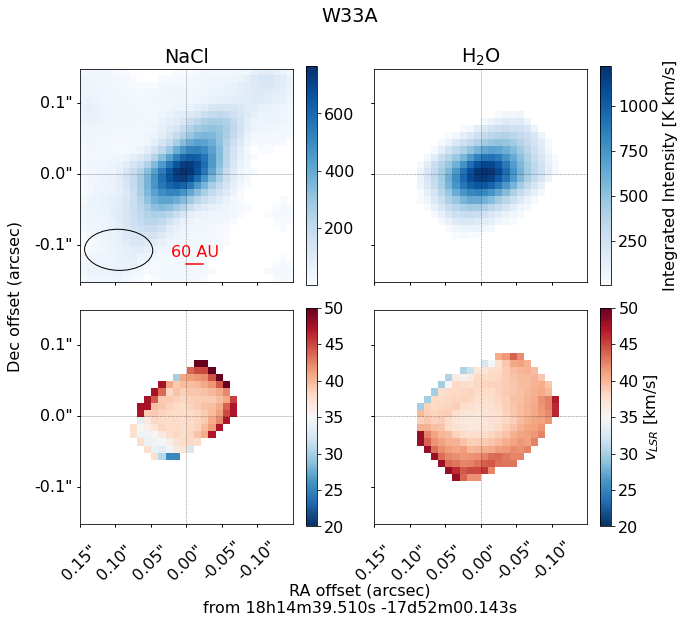

In [54]:
from dask_image.ndmorph import binary_dilation, binary_erosion

slcs = slice(None), slice(None), slice(None) #slice(4,-1), slice(6,-6)
m3dm0 = (stackc.subcube_from_regions(regvsm) > 5*u.K).include()
m3dm0 = scipy.ndimage.binary_erosion(m3dm0, iterations=1)
m3dm0 = scipy.ndimage.binary_dilation(m3dm0, iterations=2)
m3dm1 = (stackc.subcube_from_regions(regvsm) > 10*u.K).include()
m3dm1 = scipy.ndimage.binary_erosion(m3dm1, iterations=2)
m3dm1 = scipy.ndimage.binary_dilation(m3dm1, iterations=3)

m0 = stackc.subcube_from_regions(regvsm).with_mask(m3dm0)[slcs].moment0()
m1 = stackc.subcube_from_regions(regvsm).with_mask(m3dm1)[slcs].moment1()

pixscale_au = (stackc.wcs.proj_plane_pixel_area()**0.5 * distance).to(u.au, u.dimensionless_angles())

restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes
        if (c.with_spectral_unit(u.GHz).spectral_extrema[0] < restval) &
        (c.with_spectral_unit(u.GHz).spectral_extrema[1] > restval)][0]
h2ocube = watercube = scube = (cube.subcube_from_regions(regvsm)
         .with_spectral_unit(u.GHz)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))

m3dw = (h2ocube > 10*u.K).include()
m3dw = binary_erosion(m3dw, iterations=2)
m3dw = binary_dilation(m3dw, iterations=3)
m3dw = m3dw.compute()

m1h2o = scube.with_mask(m3dw)[slcs].moment1()
m0h2o = scube.with_mask(m3dw)[slcs].moment0()

fig = pl.figure(figsize=(10,9))
ax1 = pl.subplot(2,2,1, projection=m0.wcs)
im1 = ax1.imshow(m0.value, cmap='Blues', origin='lower')
ax1.set_title("NaCl")
pl.colorbar(mappable=im1)


ax2 = pl.subplot(2,2,2, projection=m0h2o.wcs)
im2 = ax2.imshow(m0h2o.value, cmap='Blues', origin='lower',)
ax2.set_title("H$_2$O")
cb2 = pl.colorbar(mappable=im2)
cb2.set_label("Integrated Intensity [K km/s]")

ax3 = pl.subplot(2,2,3, projection=m1.wcs)
im3 = ax3.imshow(m1.value, cmap='RdBu_r', origin='lower',  vmin=vcen.value-15, vmax=vcen.value+15)
pl.colorbar(mappable=im3)


ax4 = pl.subplot(2,2,4, projection=m1h2o.wcs)
im4 = ax4.imshow(m1h2o.value, cmap='RdBu_r', origin='lower', vmin=vcen.value-15, vmax=vcen.value+15)
cb4 = pl.colorbar(mappable=im4)
cb4.set_label("$v_{LSR}$ [km/s]")

dp_60 = (60*u.au / pixscale_au).decompose()
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(m0.wcs)**0.5*u.deg).to(u.arcsec))

axlims = ax1.axis()

#xc,yc = 10,12
#offset_loc = m0.wcs.celestial.pixel_to_world(xc,yc)
offset_loc = regvsm[0].center
#offset_loc = coordinates.SkyCoord("17:26:42.344 -36:09:16.14", unit=(u.h, u.deg), frame='icrs')
xc,yc = m0.wcs.celestial.world_to_pixel(offset_loc)

for ax_ in (ax1,ax2,ax3,ax4):

    xtlocs = ax_.get_xticks()
    xticklabels = map(lambda x: f"{x:0.3f}", (xc-xtlocs)*pixscale.value)
    ax_.set_xticks(xtlocs, xticklabels, rotation=45)
    ax_.axhline(yc, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    ax_.axvline(xc, color='k', linestyle='--', linewidth=0.5, alpha=0.5)

    ytlocs = ax1.get_yticks()
    yticklabels = map(lambda x: f"{x:0.3f}", (ytlocs-yc)*pixscale.value)
    ax_.set_yticks(ytlocs, yticklabels, rotation=0)

    ax_.axis(axlims)
    
    ra = ax_.coords['ra']
    ra.set_auto_axislabel(False)
    dec = ax_.coords['dec']
    ra.set_coord_type('longitude', 180)
    overlay = ax_.get_coords_overlay(offset_loc.skyoffset_frame())
    ra.set_ticklabel_visible(False)
    dec.set_ticklabel_visible(False)
    ra.set_ticks_visible(False)
    dec.set_ticks_visible(False)

    lon = overlay['lon']
    lon.set_coord_type('longitude', 180)
    lon.set_format_unit(u.arcsec)
    lon.set_ticklabel(rotation=45, pad=40)
    lon.set_ticks_position('b')
    lon.set_ticklabel_position('b')
    lon.set_axislabel_position('b')
    lon.set_axislabel(" ")
    lon.set_ticks(spacing=0.05*u.arcsec)
    lat = overlay['lat']
    lat.set_format_unit(u.arcsec)
    lat.set_ticklabel()
    lat.set_ticks_position('l')
    lat.set_ticklabel_position('l')
    lat.set_axislabel_position('l')
    lat.set_axislabel(" ")    

ax1.overlay_coords['lon'].set_ticklabel_visible(False)
ax2.overlay_coords['lon'].set_ticklabel_visible(False)
ax2.overlay_coords['lat'].set_ticklabel_visible(False)
ax4.overlay_coords['lat'].set_ticklabel_visible(False)


pl.suptitle("W33A")
blx = xc
bly = 2
ax1.plot([blx, blx+dp_60], [bly,bly], color='r')
ax1.text(blx + dp_60/2, bly+1, f'60 AU', horizontalalignment='center', color='r')

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
ax1.add_artist(bmell)


ax = fig.add_subplot(111,frameon=False)
pl.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_xlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}", labelpad=35)
ax.set_ylabel("Dec offset (arcsec)", labelpad=25)


pl.tight_layout()
pl.savefig("W33A_m0m1_grid_ticks.png", bbox_inches='tight', dpi=300)

#contrep,_ = reproject.reproject_interp(cont[0].hdu, m0.header)
#for ax_ in (ax1,ax2,ax3,ax4):
#    ax_.contour(contrep,
#                levels=[0.01, 0.02, 0.03, 0.04], colors=['k']*5, linewidths=[0.5]*5)
#pl.savefig("W33A_m0m1_grid_ticks_withcont.png", bbox_inches='tight', dpi=300)

In [55]:
pwd

'/orange/adamginsburg/salt/sanhueza/W33A'